In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [17]:
def load_grayscale_image(path):
    """
    Загружает изображение с диска и конвертирует в grayscale [0..1].
     
    Args:
         path (str): Путь до файла.
         
    Returns:
        np.ndarray: Изображение float32 в градациях серого, значения [0, 1].
    """
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Не получилось загрузить изображение: {path}")
    img = img.astype(np.float32) / 255.0
    return img

**Оператор Собеля** — это дискретный дифференциальный оператор, вычисляющий приближение градиента яркости изображения.
Оператор вычисляет градиент яркости изображения в каждой точке. Так находится направление наибольшего увеличения яркости и величина её изменения в этом направлении. Результат показывает, насколько «резко» или «плавно» меняется яркость изображения в каждой точке, а значит, вероятность нахождения точки на грани, а также ориентацию границы.


Т.о. результатом работы оператора Собеля в точке области постоянной яркости будет нулевой вектор, а в точке, лежащей на границе областей различной яркости — вектор, пересекающий границу в направлении увеличения яркости.

Оператор Собеля основан на свёртке изображения небольшими целочисленными фильтрами в вертикальном и горизонтальном направлениях, поэтому его относительно легко вычислять. Оператор использует ядра 3×3, с которыми свёртывают исходное изображение для вычисления приближенных значений производных по горизонтали и по вертикали.

In [18]:
def compute_gradients(image):
    """
    Считает градиенты по x и y, их величину и угол.

    Args:
        image (np.ndarray): Grayscale изображение float32 [0, 1].

    Returns:
        mag (np.ndarray): Величина градиента для каждого пикселя.
        angle (np.ndarray): Угол градиента в градусах [0, 180).
    """
    # Разностные операторы Собеля
    gx = cv2.Sobel(image, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(image, cv2.CV_32F, 0, 1, ksize=3)
    
    mag = np.sqrt(gx**2 + gy**2)

    angle = np.arctan2(gy, gx) # считаем в радианах
    angle = np.degrees(angle) # переводим в градусы

    angle[angle < 0] += 180.0
    return mag, angle

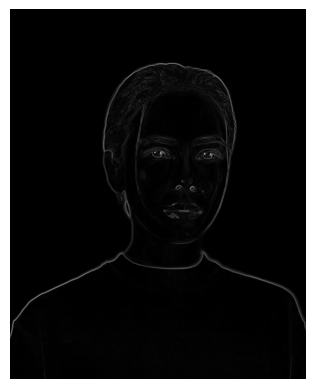

In [55]:
# Проверка функции
img = load_grayscale_image("images/2.avif")
mag, angle = compute_gradients(img)
plt.imshow(mag, cmap="gray")
plt.axis("off")
plt.show()

In [29]:
def cell_histogram(mag_cell, angle_cell, num_bins=9):
    """
    Строит гистограмму направлений градиента для одной ячейки.

    Args:
        mag_cell (np.ndarray): Величина градиента в ячейке (подматрица).
        angle_cell (np.ndarray): Угол градиента в ячейке.
        num_bins (int): Количество бинов. Если 9, то охватываем 20 градусев в диапазоне [0, 180)

    Returns:
        hist (np.ndarray): 1D гистограмма размерности [num_bins].
    """
    # Диапазон углов для HOG: [0, 180)
    bin_edges = np.linspace(0, 180, num_bins + 1)

    hist, _ = np.histogram(
        angle_cell,
        bins=bin_edges,
        weights=mag_cell
    )

    return hist.astype(np.float32)

In [56]:
cell_histogram(mag, angle)

array([4064.643 , 2481.5737, 2639.42  , 2824.9922, 3198.5342, 2826.245 ,
       2275.6172, 2207.2852, 3605.6738], dtype=float32)

In [37]:
def hog_descriptor(
    image,
    cell_size=8,
    block_size=2,
    num_bins=9,
    eps=1e-6
):
    """
    Считает HOG-дескриптор для одного grayscale изображения.

    Args:
        image (np.ndarray): Grayscale изображение float32 [0, 1].
        cell_size (int): Размер ячейки в пикселях (cell_size x cell_size).
        block_size (int): Размер блока в ячейках (block_size x block_size).
        num_bins (int): Число бинов гистограммы.
        eps (float): Маленькое число для предотвращения деления на 0.

    Returns:
        hog_vector (np.ndarray): 1D вектор признаков HOG.
        hog_cells (np.ndarray): Гистограммы по ячейкам формы [n_cells_y, n_cells_x, num_bins].
    """
    mag, angle = compute_gradients(image)
    h, w = image.shape

    # Число ячеек по вертикали и горизонтали
    n_cells_y = h // cell_size
    n_cells_x = w // cell_size

    # Обрежем изображение, чтобы оно делилось на целые ячейки
    mag = mag[:n_cells_y * cell_size, :n_cells_x * cell_size]
    angle = angle[:n_cells_y * cell_size, :n_cells_x * cell_size]

    # Гистограммы для каждой ячейки
    hog_cells = np.zeros((n_cells_y, n_cells_x, num_bins), dtype=np.float32)

    for i in range(n_cells_y):
        for j in range(n_cells_x):
            y0 = i * cell_size
            y1 = y0 + cell_size
            x0 = j * cell_size
            x1 = x0 + cell_size

            mag_cell = mag[y0:y1, x0:x1]
            angle_cell = angle[y0:y1, x0:x1]

            hog_cells[i, j] = cell_histogram(mag_cell, angle_cell, num_bins=num_bins)

    # Кол-во блоков по вертикали и горизонтали
    n_blocks_y = n_cells_y - block_size + 1
    n_blocks_x = n_cells_x - block_size + 1

    # Каждый блок: block_size * block_size ячеек, каждая по num_bins
    block_vec_len = block_size * block_size * num_bins
    hog_features = []

    for i in range(n_blocks_y):
        for j in range(n_blocks_x):
            # Берём блок гистограмм ячеек размера [block_size, block_size, num_bins]
            block = hog_cells[i:i+block_size, j:j+block_size, :]
            block = block.ravel()  # превращаем в 1D

            # L2-нормировка
            norm = np.sqrt(np.sum(block**2) + eps**2)
            block = block / norm

            hog_features.append(block)

    hog_vector = np.concatenate(hog_features, axis=0)

    return hog_vector, hog_cells

In [57]:
hog_vec, hog_cells = hog_descriptor(
    img,
    cell_size=8,
    block_size=2,
    num_bins=9
)

print("Размер HOG-вектора:", hog_vec.shape)
print("Форма массива гистограмм по ячейкам:", hog_cells.shape)

Размер HOG-вектора: (399312,)
Форма массива гистограмм по ячейкам: (119, 95, 9)


In [67]:
def visualize_hog_simple(image, hog_cells, cell_size=8, num_bins=9, scale=6.0, step=1):
    """
    Простая и читабельная визуализация HOG.

    В каждой ячейке рисуем ОДНУ линию:
    - направление = бин с максимальным значением,
    - длина = максимальная длина (масштаб scale).

    Args:
        image (np.ndarray): исходное grayscale изображение.
        hog_cells (np.ndarray): массив гистограмм [n_cells_y, n_cells_x, num_bins].
        cell_size (int): размер ячейки (в пикселях).
        num_bins (int): количество бинов HOG.
        scale (float): длина линии (чем больше, тем длиннее штрихи).
        step (int): через сколько ячеек рисовать (1 — каждую, 2 — каждую вторую и т.д.).
    """
    img = image.astype(np.float32)
    if img.max() > 1.5:
        img = img / 255.0

    n_cells_y, n_cells_x, _ = hog_cells.shape

    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap="gray")
    plt.axis("off")

    # центры бинов (углы) в градусах
    bin_angles = np.linspace(0, 180, num_bins, endpoint=False)

    for i in range(0, n_cells_y, step):
        for j in range(0, n_cells_x, step):
            hist = hog_cells[i, j]
            if hist.sum() == 0:
                continue

            # выбираем ТОЛЬКО самый сильный бин
            b = np.argmax(hist)
            angle_deg = bin_angles[b]
            angle = np.deg2rad(angle_deg)

            # центр ячейки
            y_center = i * cell_size + cell_size / 2
            x_center = j * cell_size + cell_size / 2

            # длина линии (одинаковая для всех, чтобы было понятно)
            length = scale
            dx = length * np.cos(angle)
            dy = length * np.sin(angle)

            x0 = x_center - dx / 2
            y0 = y_center - dy / 2
            x1 = x_center + dx / 2
            y1 = y_center + dy / 2

            # рисуем ОДНИМ цветом
            plt.plot([x0, x1], [y0, y1], color="lime", linewidth=0.7)

    plt.title("HOG: главное направление границы в каждой ячейке")
    plt.show()


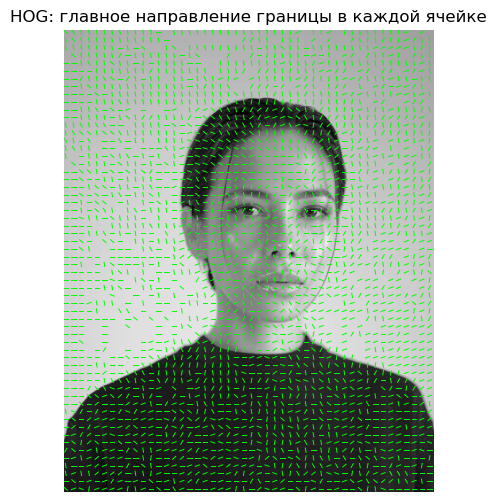

In [68]:
visualize_hog_simple(
    img,
    hog_cells,
    cell_size=8,
    num_bins=9,
    scale=9.0,
    step=2 # рисуем каждую вторую ячейку, чтобы было чище
)